**Imports and Directory Set Up** 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
os.chdir("/kaggle/input/")
checkpoints= '/checkpoint'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '../input/birds23sp/birds/'

**Image Transformation and Data Loaders**

In [2]:
# Define the transformation for the images
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

# Load the bird dataset
dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)

# Create a Validation set out of the data set
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset= datasets.ImageFolder(os.path.join(data_dir, 'test'), transform = transform_test)

# Data loaderssss 
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers = 2)

**Model Set Up**

In [3]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')

# Freeze 
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of bird classes
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x16-c6f796b0.pth
100%|██████████| 741M/741M [00:03<00:00, 224MB/s]  


**Training**

In [4]:
# Training loop
best_val_acc = 0.0
num_epochs = 10
losses = list()
accuracies = list()

for epoch in range(num_epochs):
    sum_loss = 0.0
    # Training phase
    model.train()
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
    
    #Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            val_loss += criterion(outputs, labels).item()
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_dataset)
    losses.append(val_loss)
    accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    
    #store best checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = '/checkpoint/checkpoint.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, checkpoint_path)

Epoch [1/10], Val Loss: 2.4402, Val Accuracy: 0.4367
Epoch [2/10], Val Loss: 2.3585, Val Accuracy: 0.4754
Epoch [3/10], Val Loss: 2.2171, Val Accuracy: 0.5161
Epoch [4/10], Val Loss: 2.3098, Val Accuracy: 0.5288
Epoch [5/10], Val Loss: 2.2605, Val Accuracy: 0.5379
Epoch [6/10], Val Loss: 2.2387, Val Accuracy: 0.5573
Epoch [7/10], Val Loss: 2.3215, Val Accuracy: 0.5545
Epoch [8/10], Val Loss: 2.3422, Val Accuracy: 0.5617
Epoch [9/10], Val Loss: 2.4347, Val Accuracy: 0.5576
Epoch [10/10], Val Loss: 2.5601, Val Accuracy: 0.5615


**Prediction**

In [5]:
def predict(model, dataloader, output_file):
    model.to(device)
    model.eval()
    results = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(preds)):
                filename, _ = dataloader.dataset.samples[i]
                class_idx = preds[i].item()
                class_name = dataset.classes[class_idx]
                results.append((filename.split('/')[-1], class_name))

    # Save the predictions to a CSV file
    with open(output_file, 'w') as file:
        file.write("path,class\n")
        for filename, class_name in results:
            file.write(f"test/{filename},{class_name}\n")

**Plots**

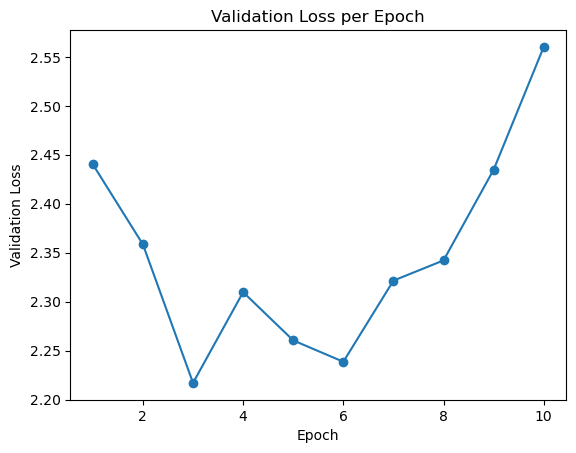

In [6]:
epoches = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure()
plt.plot(epoches, losses, marker='o')  

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Epoch")

plt.show()

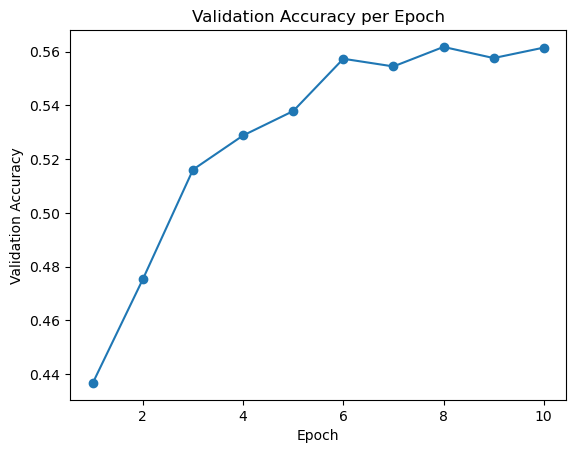

In [7]:
plt.figure()
plt.plot(epoches, accuracies, marker='o')

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")

plt.show()

In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
output_file = '../working/predictions.csv'
predict(model, test_loader, output_file)

print("Predictions saved to:", output_file)